# Lab 2

### Main aims of the laboratory:
 1. Getting familiar with logistic regression algorithm
 2. Imputation methods (Mice + KNN algorithm)

In [2]:
import pandas as pd
dataset = pd.read_csv("titanic.csv")

In [3]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# checking for non NA missing values

numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
dataset[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce')).isna().sum()

Survived      0
Pclass        0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64

In [6]:
for i in [1,2,4,6,7,11]:
    x = dataset.iloc[:,i].unique()
    print(dataset.columns[i], "levels:", x, "\n")

Survived levels: [0 1] 

Pclass levels: [3 1 2] 

Sex levels: ['male' 'female'] 

SibSp levels: [1 0 3 4 2 5 8] 

Parch levels: [0 1 2 5 3 4 6] 

Embarked levels: ['S' 'C' 'Q' nan] 



In [7]:
# variables selection

# removing - PassengerId, Name, Ticket - not significant variables for our task
# removing - Cabin - majority of observations have gaps (not significant variables)

dataset = dataset.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# dropping all rows with missing values
dataset = dataset.dropna()

## Cleaning dataset

In [8]:
# coding sex variable

dataset['Sex'] = dataset['Sex'].replace({'male': 1, 'female': 0})

# coding embarked variable

dummies = embarked_dummies = pd.get_dummies(dataset['Embarked'], dtype=int)
dataset = pd.concat([dataset, dummies], axis=1).drop('Embarked', axis=1)

C:\Users\spoko\AppData\Local\Temp\ipykernel_15696\511536194.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Sex'] = dataset['Sex'].replace({'male': 1, 'female': 0})


## Additional part of the laboratory (Grouping variables and anomalies detection)

### Example of groupping

Text(0.5, 0, 'Parch')

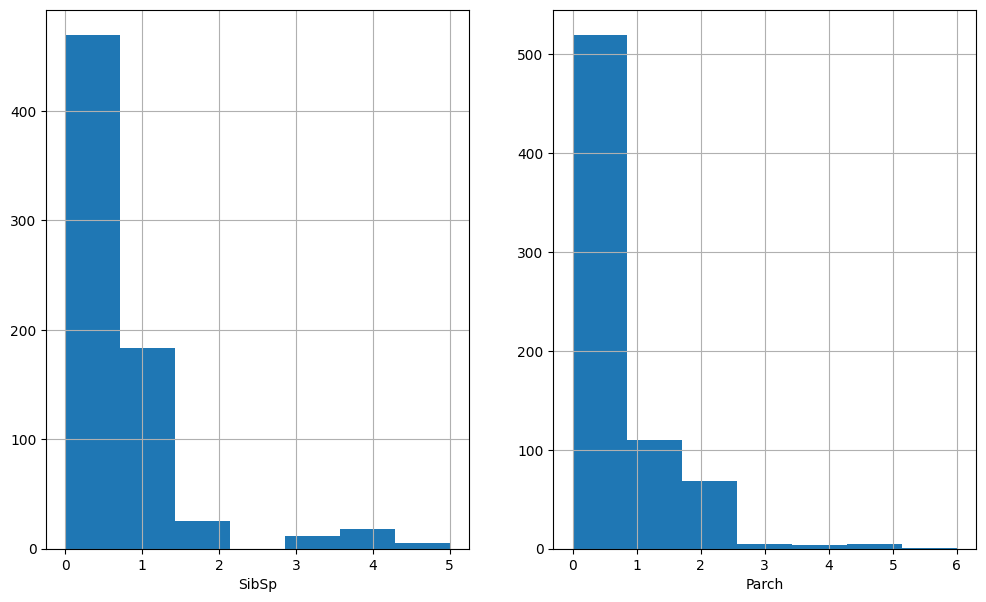

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
dataset['SibSp'].hist(bins=7)
plt.xlabel("SibSp")

plt.subplot(1,2,2)
dataset['Parch'].hist(bins=7)
plt.xlabel("Parch")

In [10]:
dataset['SibSp'].value_counts()

SibSp
0    469
1    183
2     25
4     18
3     12
5      5
Name: count, dtype: int64

In [11]:
dataset['Parch'].value_counts()

Parch
0    519
1    110
2     68
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [12]:
# Connecting categories (Category 2 - will be understood as equal or more than 2 parents, children)
# Benefits - higher stability of learning process (more balanced classes) and easier interpretation

dataset['SibSp'] = dataset['SibSp'].replace([2,3,4,5],1)
dataset['Parch'] = dataset['Parch'].replace([2,3,4,5,6],1)

In [13]:
dataset['SibSp'].value_counts()

SibSp
0    469
1    243
Name: count, dtype: int64

In [14]:
dataset['Parch'].value_counts()

Parch
0    519
1    193
Name: count, dtype: int64

## Anomaly detection - dropping such observations using DBSCAN

Estimated number of clusters: 1
Estimated number of noise points: 35


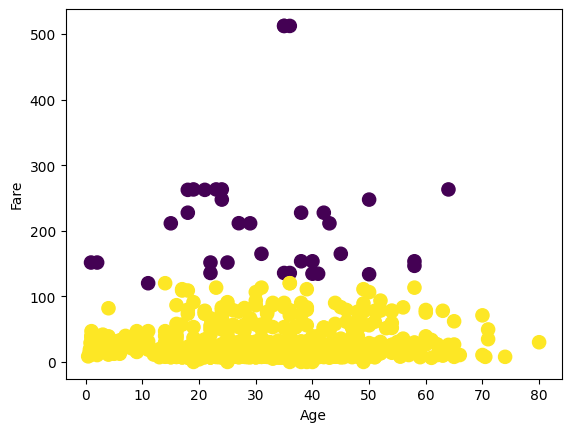

In [100]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=22, min_samples=18).fit(dataset)
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

plt.scatter(dataset['Age'], dataset['Fare'], c = labels, s=90)
plt.xlabel("Age")
plt.ylabel("Fare")
plt.show()

$35 \approx 5\%$ what suggest that we can drop estimated outliers.

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
import numpy as np

# custom annomalies dropper

class DBSCANoutliers(BaseEstimator, TransformerMixin):
    def __init__(self, eps = 22, min_samples = 18):
        self.eps = eps
        self.min_samples = min_samples

    def fit(self, X, y=None):
        self.dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples).fit(X)
        return self
    
    def transform(self, X, y=None):
        labels = self.dbscan.labels_
        X_clean = X.copy()
        X_clean[labels == -1] = np.nan
        return X_clean

### Checking densities

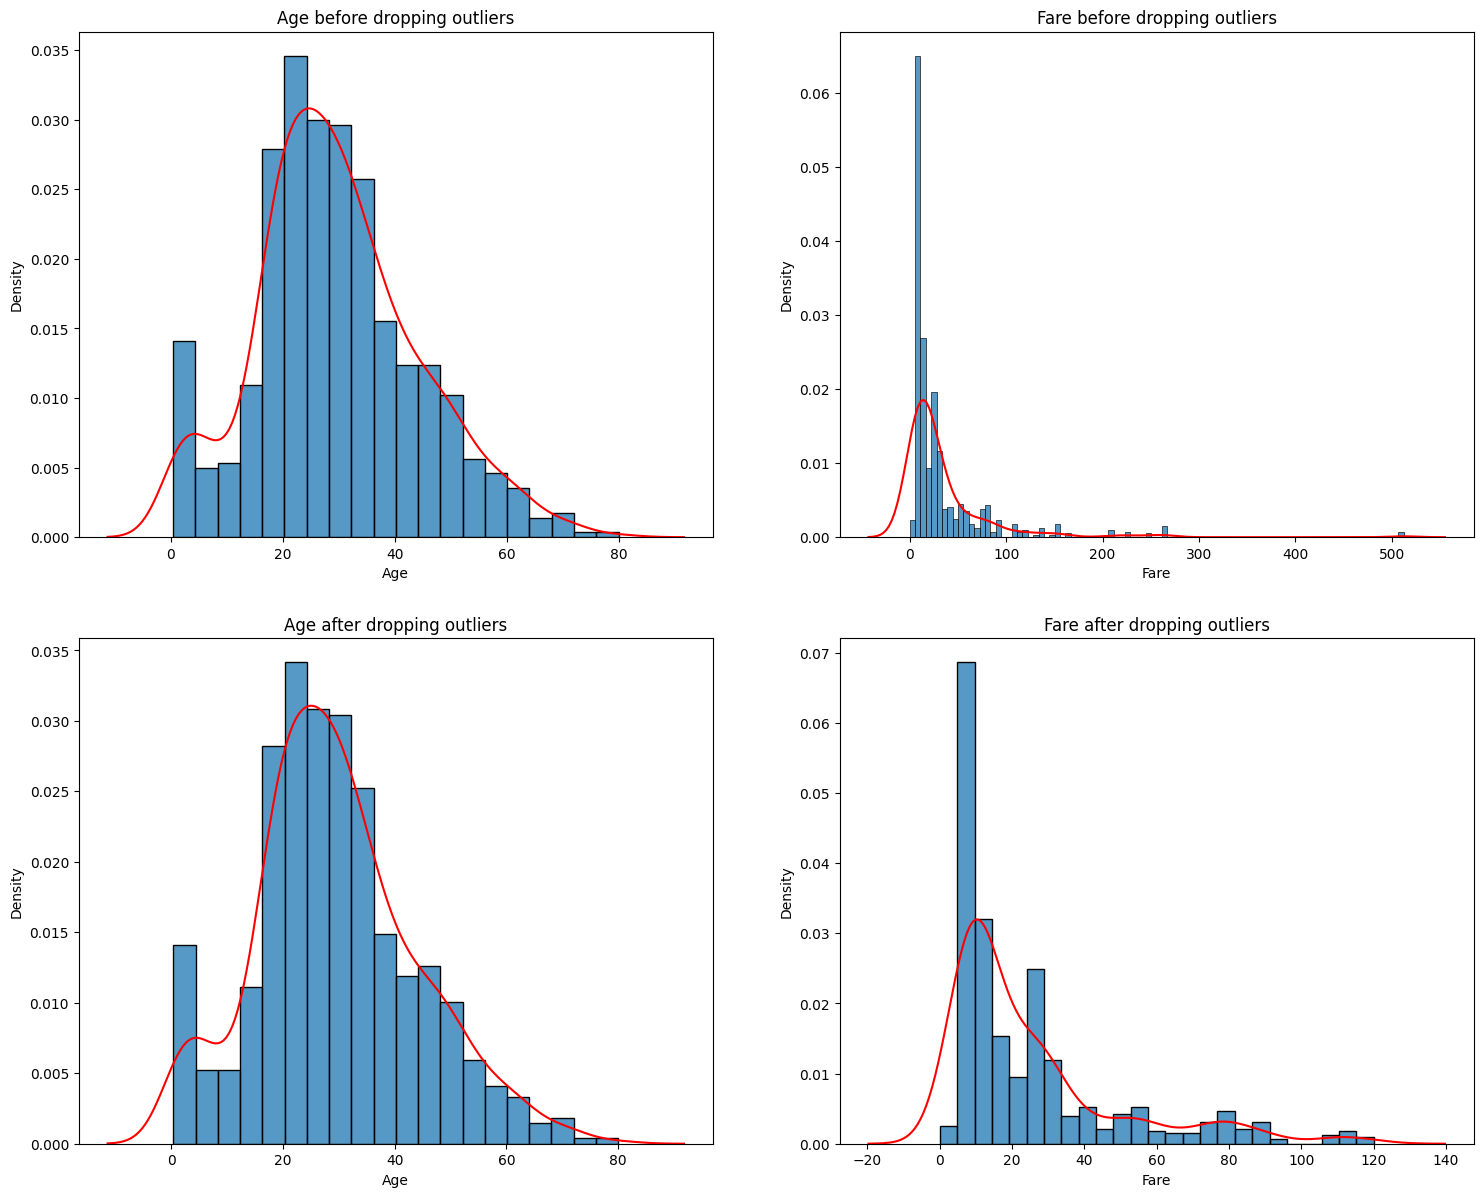

In [17]:
import seaborn as sn



plt.figure(figsize=(18,8))

plt.subplots_adjust(top = 1.5)

plt.subplot(2,2,1)
sn.histplot(dataset['Age'], stat='density')
sn.kdeplot(dataset['Age'], color='red')
plt.title("Age before dropping outliers")

plt.subplot(2,2,2)
sn.histplot(dataset['Fare'], stat='density')
sn.kdeplot(dataset['Fare'], color='red')
plt.title("Fare before dropping outliers")

plt.subplot(2,2,3)
sn.histplot(dataset['Age'].iloc[labels != -1], stat='density')
sn.kdeplot(dataset['Age'].iloc[labels != -1], color='red')
plt.title("Age after dropping outliers")

plt.subplot(2,2,4)
sn.histplot(dataset['Fare'].iloc[labels != -1], stat='density')
sn.kdeplot(dataset['Fare'].iloc[labels != -1], color='red')
plt.title("Fare after dropping outliers")

plt.show()

The mere removal of outliers helped the ‘fare’ variable to approach a normal distribution, but that’s not enough, we can try other techniques of mapping data to a normal distribution e.g. Box-Cox transformation.

In [18]:
x[1]

'C'

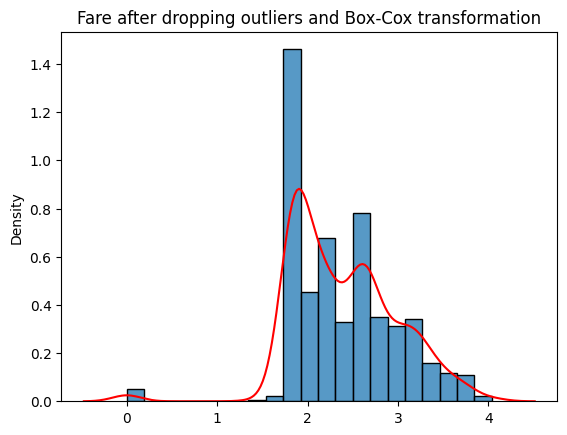

In [19]:
from scipy.stats import boxcox

# lambda

#x = boxcox(dataset['Fare']+1)
#x[0]

plt.figure()

sn.histplot(boxcox(dataset['Fare']+1)[0], stat='density')
sn.kdeplot(boxcox(dataset['Fare']+1)[0], color='red')
plt.title("Fare after dropping outliers and Box-Cox transformation")

plt.show()

value of lmbda that maximizes the log-likelihood function $ \approx -0.15$ 

In [74]:
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lmbda=-0.15):
        self.lmbda = lmbda

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_plus_one = X + 1
        X_transformed = boxcox(X_plus_one, lmbda=self.lmbda).reshape(-1,1)

        return X_transformed

In [38]:
labels = dbscan.labels_
X_clean = dataset[['Fare', 'Age']][labels != -1]

X_clean.shape

(677, 2)

In [66]:
X_plus_one = dataset['Fare'] + 1
X_transformed = boxcox(X_plus_one, lmbda=-0.15).reshape(-1,1)

df_transformed = pd.DataFrame(X_transformed)
df_transformed.index = dataset.index
df_transformed

,0
0,1.808855
1,3.158719
2,1.865824
3,3.002889
4,1.875829
...,...
885,2.666577
886,2.179321
887,2.683720
889,2.683720


## Modelling Process

### First model - without dropping anomalies and distribution transform

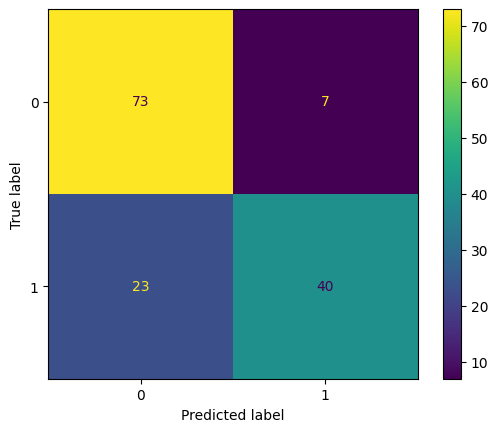

accuracy: 0.7902097902097902
F1 score: 0.7272727272727273


In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

X_train, y_train = train_dataset.iloc[:,1:], train_dataset.iloc[:,0]
X_test, y_test = test_dataset.iloc[:,1:], test_dataset.iloc[:,0]

clf_model = make_pipeline(StandardScaler(), LogisticRegression())
clf1 = clf_model.fit(X_train, y_train)

predictions1 = clf1.predict(X_test)

confmat = confusion_matrix(y_test, predictions1)

ConfusionMatrixDisplay(confusion_matrix = confmat).plot()
plt.show()

print("accuracy:",accuracy_score(y_test, predictions1))
print("F1 score:",f1_score(y_test, predictions1))

### Second model - without dropping anomalies

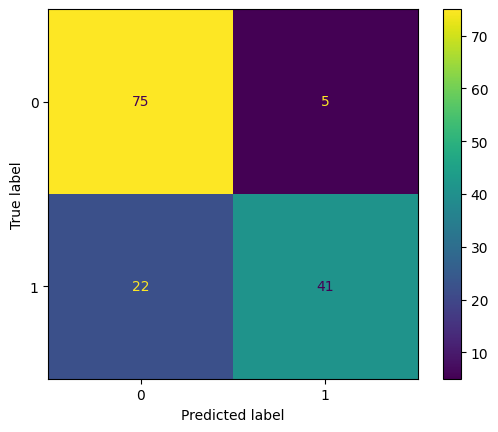

accuracy: 0.8111888111888111
F1 score: 0.7522935779816514


In [202]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

distribution_transformer = BoxCoxTransformer()

train_dataset['Age'] = distribution_transformer.fit_transform(train_dataset['Age'])
test_dataset['Age'] = distribution_transformer.fit_transform(test_dataset['Age'])

X_train, y_train = train_dataset.iloc[:,1:], train_dataset.iloc[:,0]
X_test, y_test = test_dataset.iloc[:,1:], test_dataset.iloc[:,0]


clf2 = clf_model.fit(X_train, y_train)

predictions2 = clf2.predict(X_test)

confmat = confusion_matrix(y_test, predictions2)

ConfusionMatrixDisplay(confusion_matrix = confmat).plot()
plt.show()

print("accuracy:",accuracy_score(y_test, predictions2))
print("F1 score:",f1_score(y_test, predictions2))

### Third model - with all preprocessing

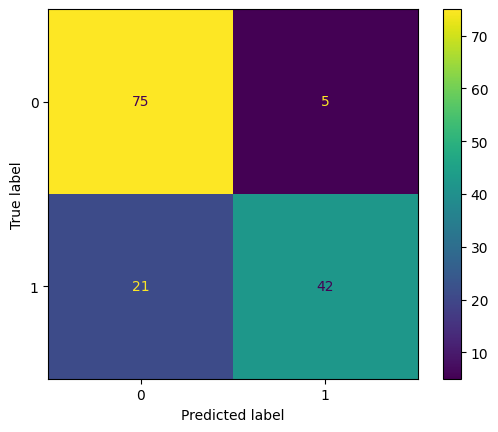

accuracy: 0.8181818181818182
F1 score: 0.7636363636363637


In [203]:
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import PowerTransform
from sklearn.pipeline import make_pipeline

#train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

outliers_transformer = DBSCANoutliers()
distribution_transformer = BoxCoxTransformer()

# preprocessing = ColumnTransformer([
#     ('outliers', outliers_transformer, ['Fare','Age']),
#     ('distribution', distribution_transformer, ['Age']),], 
#     remainder='passthrough')


# train_dataset_preprocess = preprocessing.fit_transform(train_dataset)
# pd.DataFrame(train_dataset_preprocess)

train_dataset[['Fare','Age']] = outliers_transformer.fit_transform(train_dataset[['Fare','Age']])
train_dataset = train_dataset.dropna()

X_train, y_train = train_dataset.iloc[:,1:], train_dataset.iloc[:,0]
X_test, y_test = test_dataset.iloc[:,1:], test_dataset.iloc[:,0]


clf2 = clf_model.fit(X_train, y_train)

predictions2 = clf2.predict(X_test)

confmat = confusion_matrix(y_test, predictions2)

ConfusionMatrixDisplay(confusion_matrix = confmat).plot()
plt.show()

print("accuracy:",accuracy_score(y_test, predictions2))
print("F1 score:",f1_score(y_test, predictions2))



### Conclusions

 - Droping anomalies didn't change anything because of dataset size
 - Logistic Regression is a kind of simple algorithm assuming linear dependency between log-odds and predictors (when the relation is more complex it is difficult to model it using Logistic Regression - even using transformations and cleaning steps for the dataset). Thus, we have noticed only minimal improvement.

### Different possible problems

 - Almost 170 missing values dropped at the beginning of the process (mainly because of Age variable) - it is worth performing imputation methods
 - Unbalanced dependent variable - try to use **SMOTE methods**
 - Building model using only generated observations and then checking accuracy on the real dataset